Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [11]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [12]:
## Mounting the data from google drive:
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [13]:
root_path = '/content/gdrive/My Drive/CNN_assignment/'

In [15]:
# # Defining the path for train and test images
# ## Todo: Update the paths of the train and test dataset 
data_dir_train = pathlib.Path("/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [16]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [17]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [18]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [19]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [20]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

<ipython-input-21-8a2ebaf1ebdf>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(3, 3, i + 1)


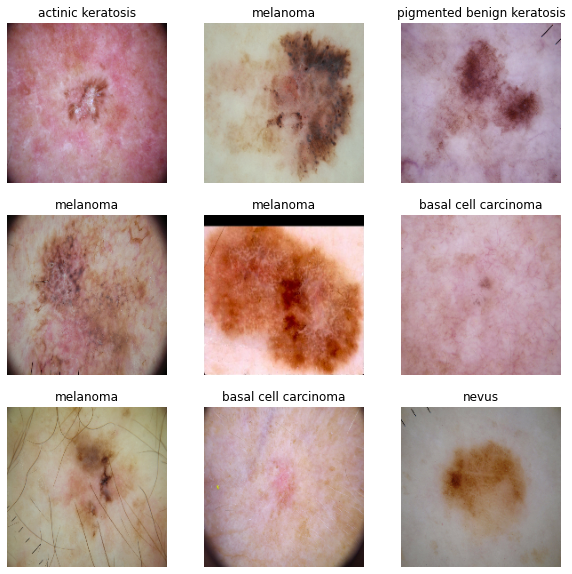

In [21]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(10):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [23]:
### Your code goes here
num_classes = 9

#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [24]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [26]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 225s 1s/step - loss: 1.9546 - accuracy: 0.2952 - val_loss: 1.7497 - val_accuracy: 0.3915
Epoch 2/20
56/56 [==============================] - 1s 25ms/step - loss: 1.6218 - accuracy: 0.4425 - val_loss: 1.5068 - val_accuracy: 0.5011
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4791 - accuracy: 0.4816 - val_loss: 1.4712 - val_accuracy: 0.5414
Epoch 4/20
56/56 [==============================] - 1s 23ms/step - loss: 1.3669 - accuracy: 0.5357 - val_loss: 1.5128 - val_accuracy: 0.4743
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.2972 - accuracy: 0.5285 - val_loss: 1.3492 - val_accuracy: 0.5414
Epoch 6/20
56/56 [==============================] - 1s 23ms/step - loss: 1.2012 - accuracy: 0.5753 - val_loss: 1.4178 - val_accuracy: 0.5302
Epoch 7/20
56/56 [==============================] - 1s 23ms/step - loss: 1.2833 - accuracy: 0.5346 - val_loss: 1.5300 - val_accuracy: 0.4765
Epoch 8/20
56

### Visualizing training results

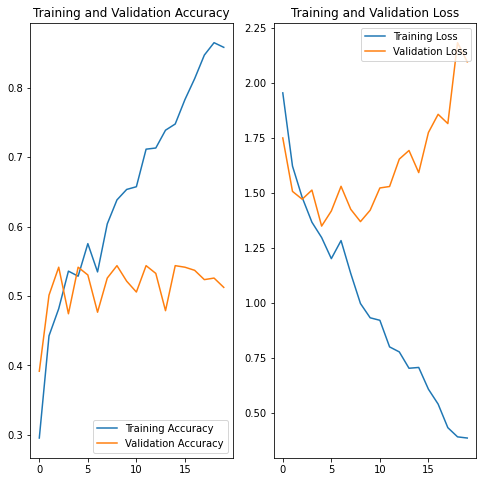

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here





*   Training accuracy of the model seems to increase linearly whereas validation accuracy remained stagnant around 55%
*   High training accuracy means the model has learnt the noise in the data as well, however its poor performance on validation data shows lack of generalisability of the model.

*   The above observations confirm the case of overfitting. To mitigate overfitting augmentation technique will be used.
*   Since the training data available is less, we will generate new samples by slightly modifying the existing training data (for eg. flipping the image horizontally/vertically, slightly rotating the image etc) and use them for training the model as well.




In [28]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential([
                                      layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                                      layers.experimental.preprocessing.RandomRotation(0.1),
                                      layers.experimental.preprocessing.RandomZoom(0.1),
])

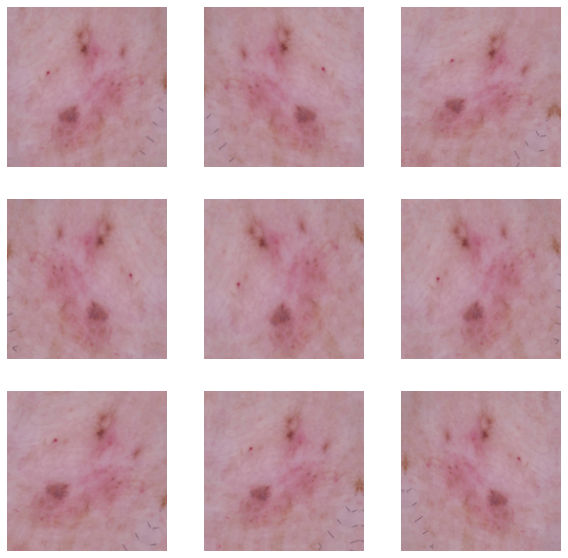

In [29]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [30]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compiling the model

In [31]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [32]:
## Your code goes here, note: train your model for 20 epochs
 
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 44ms/step - loss: 1.8986 - accuracy: 0.3125 - val_loss: 1.6297 - val_accuracy: 0.4295
Epoch 2/20
56/56 [==============================] - 2s 41ms/step - loss: 1.5964 - accuracy: 0.4269 - val_loss: 1.4974 - val_accuracy: 0.5011
Epoch 3/20
56/56 [==============================] - 2s 41ms/step - loss: 1.4608 - accuracy: 0.4900 - val_loss: 1.4713 - val_accuracy: 0.4832
Epoch 4/20
56/56 [==============================] - 2s 40ms/step - loss: 1.4257 - accuracy: 0.4922 - val_loss: 1.3939 - val_accuracy: 0.5168
Epoch 5/20
56/56 [==============================] - 2s 41ms/step - loss: 1.3406 - accuracy: 0.5251 - val_loss: 1.3396 - val_accuracy: 0.5503
Epoch 6/20
56/56 [==============================] - 2s 41ms/step - loss: 1.2901 - accuracy: 0.5379 - val_loss: 1.3389 - val_accuracy: 0.5414
Epoch 7/20
56/56 [==============================] - 2s 41ms/step - loss: 1.2912 - accuracy: 0.5441 - val_loss: 1.4290 - val_accuracy: 0.5034
Epoch 8/20
56

### Visualizing the results

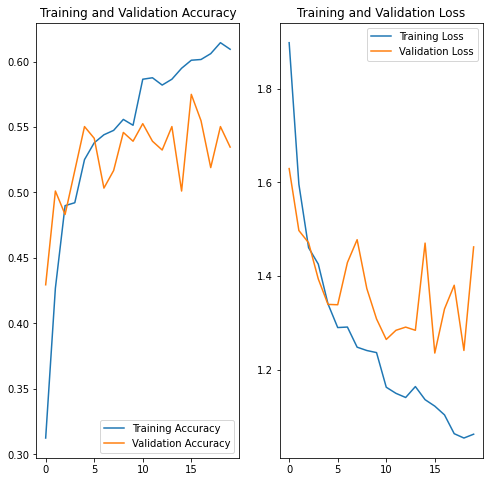

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
     

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?




*  With the help of augmented data, the problem of overfitting is mitigated.
*  Training and validation accuracy of the above model are in the same range.
*  The model is performing poorly both on training data and validation data- i.e. the model is underfitting now






#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [34]:
## Your code goes here.
from glob import glob
path_list = [ x for x in glob(os.path.join(data_dir_train, '*', '*.jpg')) ] 
lesion_list = [ os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesion_list))

2239


In [35]:
df_dict_original = dict(zip(path_list, lesion_list))
print(list(df_dict_original.items())[:2])

[('/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026468.jpg', 'actinic keratosis'), ('/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025825.jpg', 'actinic keratosis')]


In [36]:

original_df = pd.DataFrame(list(df_dict_original.items()), columns=['Path','Label'])
original_df.head()

,Path,Label
0,/content/gdrive/My Drive/CNN_assignment/Skin c...,actinic keratosis
1,/content/gdrive/My Drive/CNN_assignment/Skin c...,actinic keratosis
2,/content/gdrive/My Drive/CNN_assignment/Skin c...,actinic keratosis
3,/content/gdrive/My Drive/CNN_assignment/Skin c...,actinic keratosis
4,/content/gdrive/My Drive/CNN_assignment/Skin c...,actinic keratosis


In [37]:
original_df[['Label']].value_counts()


Label                     
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
dtype: int64

In [38]:
original_df[['Label']].value_counts(normalize=True)


Label                     
pigmented benign keratosis    0.206342
melanoma                      0.195623
basal cell carcinoma          0.167932
nevus                         0.159446
squamous cell carcinoma       0.080840
vascular lesion               0.062081
actinic keratosis             0.050916
dermatofibroma                0.042430
seborrheic keratosis          0.034390
dtype: float64

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?




*   'seborrheic keratosis' has the least number of samples
*   The classes 'pigmented benign keratosis' and 'melanoma' dominate the data with 20.6% and 19.5% samples respectively.



#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [39]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [40]:
path_to_training_dataset=str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F80B054E190>: 100%|██████████| 500/500 [00:25<00:00, 19.88 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F80B0511B20>: 100%|██████████| 500/500 [00:23<00:00, 21.38 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F80B4761AC0>: 100%|██████████| 500/500 [00:18<00:00, 27.55 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F80B39CA5E0>: 100%|██████████| 500/500 [01:22<00:00,  6.04 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F812F98EC10>: 100%|██████████| 500/500 [01:25<00:00,  5.87 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F80B47AAA00>: 100%|██████████| 500/500 [00:18<00:00, 27.78 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F80B474B700>: 100%|██████████| 500/500 [00:42<00:00, 11.78 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F80B0691100>: 100%|██████████| 500/500 [00:18<00:00, 27.69 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F812F9F67C0>: 100%|██████████| 500/500 [00:17<00:00, 28.48 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [41]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [42]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:5]

['/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030408.jpg_6524729e-6f36-45fb-bff5-546d7eca4498.jpg',
 '/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029460.jpg_7bdf8b62-9930-4285-bf4f-15fdbb5aad22.jpg',
 '/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026857.jpg_ad6d8c40-a260-4fca-b229-061ac6ba79b7.jpg',
 '/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026984.jpg_8873e301-eb95-4144-9a2f-f468811ecf5b.jpg',
 '/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/ac

In [43]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [44]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [45]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)
new_df.shape

(6739, 2)

In [46]:
new_df.head()

,Path,Label
0,/content/gdrive/My Drive/CNN_assignment/Skin c...,actinic keratosis
1,/content/gdrive/My Drive/CNN_assignment/Skin c...,actinic keratosis
2,/content/gdrive/My Drive/CNN_assignment/Skin c...,actinic keratosis
3,/content/gdrive/My Drive/CNN_assignment/Skin c...,actinic keratosis
4,/content/gdrive/My Drive/CNN_assignment/Skin c...,actinic keratosis


In [47]:
# Checking the class distribution after adding 500 samples per label
new_df['Label'].value_counts(normalize=True)

pigmented benign keratosis    0.142751
melanoma                      0.139190
basal cell carcinoma          0.129990
nevus                         0.127170
squamous cell carcinoma       0.101054
vascular lesion               0.094821
actinic keratosis             0.091111
dermatofibroma                0.088292
seborrheic keratosis          0.085621
Name: Label, dtype: float64

In [48]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [49]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [50]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)
     

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [51]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [52]:
## your code goes here
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
     

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [53]:
## your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [54]:

epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 34s 191ms/step - loss: 1.8870 - accuracy: 0.2711 - val_loss: 1.5310 - val_accuracy: 0.4039
Epoch 2/30
169/169 [==============================] - 33s 187ms/step - loss: 1.5122 - accuracy: 0.4310 - val_loss: 1.3919 - val_accuracy: 0.4714
Epoch 3/30
169/169 [==============================] - 34s 196ms/step - loss: 1.4225 - accuracy: 0.4668 - val_loss: 1.3212 - val_accuracy: 0.5026
Epoch 4/30
169/169 [==============================] - 32s 186ms/step - loss: 1.3598 - accuracy: 0.4844 - val_loss: 1.2989 - val_accuracy: 0.5338
Epoch 5/30
169/169 [==============================] - 33s 187ms/step - loss: 1.2804 - accuracy: 0.5083 - val_loss: 1.2439 - val_accuracy: 0.5189
Epoch 6/30
169/169 [==============================] - 33s 188ms/step - loss: 1.2627 - accuracy: 0.5204 - val_loss: 1.2857 - val_accuracy: 0.5137
Epoch 7/30
169/169 [==============================] - 33s 187ms/step - loss: 1.2097 - accuracy: 0.5321 - val_loss: 1.2254 - val_ac

#### **Todo:**  Visualize the model results

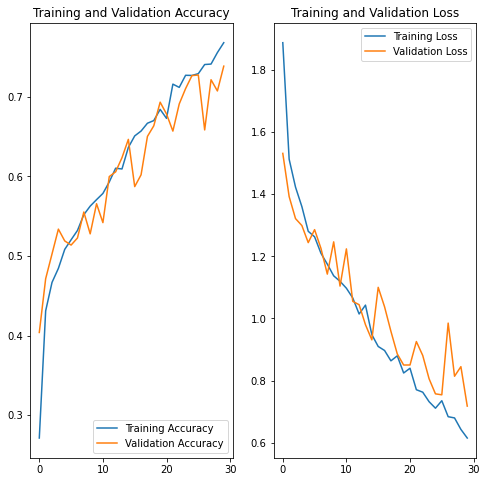

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Comment:

*   In the final model, there is no sign of underfitting/overfitting.

*   Class rebalanced improved the model performance on both training and validation data
*   In 30 epochs, the final model is able to achieve 76.8% training accuracy and 73.8% validation accuracy.
*   The low difference between the training accuracy and validation accuracy signifies that the final CNN model is able to generalize well.
*   Inclusion of batch normalization is degrading the accuracy of the final model, hence it is not used.